In [5]:
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import mxnet.ndarray as nd
import numpy as np

# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [6]:
ctx = mx.cpu()

mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                               mnist["train_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=False)

In [7]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(10))

In [8]:
#Xavier initialization for weights
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

In [9]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [10]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.0})

In [11]:
def evaluate_accuracy(data_iterator, net, loss_fun):
    acc = mx.metric.Accuracy()
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        output = net(data)
        loss = loss_fun(output, label)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return acc.get()[1], loss_avg

def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

Completed epoch 1. Train Loss: 2.18301233649, Test Loss 2.20795860887, Train_acc 0.24, Test_acc 0.206
Completed epoch 21. Train Loss: 0.900843668729, Test Loss 1.10199328139, Train_acc 0.827, Test_acc 0.738
Completed epoch 41. Train Loss: 0.65825073421, Test Loss 0.871699638665, Train_acc 0.864, Test_acc 0.768
Completed epoch 61. Train Loss: 0.545716596767, Test Loss 0.767511267215, Train_acc 0.878, Test_acc 0.784
Completed epoch 81. Train Loss: 0.485070802271, Test Loss 0.705586589873, Train_acc 0.889, Test_acc 0.797
Completed epoch 101. Train Loss: 0.440400388092, Test Loss 0.664287921041, Train_acc 0.898, Test_acc 0.808
Completed epoch 121. Train Loss: 0.408896323293, Test Loss 0.633925888687, Train_acc 0.904, Test_acc 0.817
Completed epoch 141. Train Loss: 0.382769839838, Test Loss 0.610991563648, Train_acc 0.914, Test_acc 0.818
Completed epoch 161. Train Loss: 0.36031408608, Test Loss 0.592402158305, Train_acc 0.916, Test_acc 0.823
Completed epoch 181. Train Loss: 0.343643269502, 

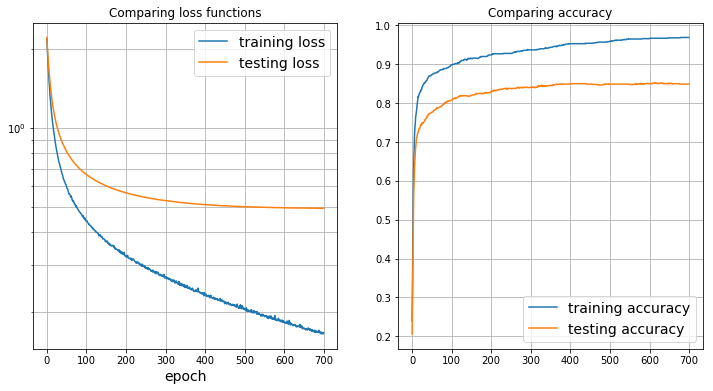

In [12]:
epochs = 700
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net, loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 20 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))

## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

### Regularization

- When we add an L2 penalty to the weights we are effectively adding λ/2*‖w‖2 to the loss. 

- Hence, every time we compute the gradient it gets an additional λw term that is added to gt, since this is the very derivative of the L2 penalty. 

- As a result we end up taking a descent step not in the direction −ηgt but rather in the direction −η(gt+λw). 

- This effectively shrinks w at each step by ηλw, thus the name weight decay. 

- To make this work in practice we just need to set the weight decay to something nonzero.

Completed epoch 1. Train Loss: 2.16098457575, Test Loss 2.22431474924, Train_acc 0.204, Test_acc 0.184
Completed epoch 21. Train Loss: 0.89859746024, Test Loss 1.10961798579, Train_acc 0.835, Test_acc 0.736
Completed epoch 41. Train Loss: 0.658557889983, Test Loss 0.875157006085, Train_acc 0.865, Test_acc 0.766
Completed epoch 61. Train Loss: 0.551647948101, Test Loss 0.770862478763, Train_acc 0.88, Test_acc 0.786
Completed epoch 81. Train Loss: 0.487508509308, Test Loss 0.708873044699, Train_acc 0.887, Test_acc 0.802
Completed epoch 101. Train Loss: 0.444737810642, Test Loss 0.667089160532, Train_acc 0.899, Test_acc 0.808
Completed epoch 121. Train Loss: 0.408854946494, Test Loss 0.636825518683, Train_acc 0.909, Test_acc 0.819
Completed epoch 141. Train Loss: 0.38558241725, Test Loss 0.613780055195, Train_acc 0.915, Test_acc 0.825
Completed epoch 161. Train Loss: 0.360977940261, Test Loss 0.595127174631, Train_acc 0.92, Test_acc 0.829
Completed epoch 181. Train Loss: 0.344635332003, T

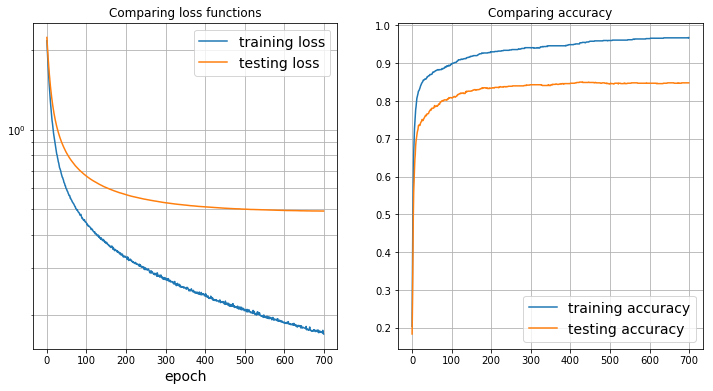

In [15]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx, force_reinit=True)

# `wd` is the weight decay value. Weight decay is exactly the lambda value for L2 penalization.
# L1 penalization is more difficult and requires `proximal operators`
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.0005})

moving_loss = 0.
niter=0
loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net,loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)

    if e % 20 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))

## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)
